# Data Analytics - project script
## Derek Lukacsko

In [9]:
import sentisignal
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [127]:
import pandas as pd
import numpy as np 
import pylab as P 
import ast
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import math
import scipy.stats as s
import statsmodels.api as sm
import pprint
import seaborn as sns

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from datetime import datetime
from yahoo_finance import Share
from pandas_datareader import data, wb
from statsmodels.graphics.api import qqplot
from operator import itemgetter
from decimal import *
from pylab import figure, axes, pie, title, show
from sklearn.neighbors.kde import KernelDensity
# plt.style.use('ggplot')
# sns.set_style("darkgrid")
# sns.set_context("notebook")

In [11]:
data_primary_path = '../../data/csv/stocktwits_twitter_withretweets_daily.csv'
data_symbology_path = '../../data/csv/symbology.csv'
data_pickles_path = '../../data/pickles/'
data_nasdaq_company_list_path = '../../data/csv/NYSE.csv'
start_date = '2012-01-01'
end_date = '2016-01-01'
data_symbology = pd.read_csv(data_symbology_path)

# Descriptive Statistics

In [12]:
data_nasdaq_company_list = pd.read_csv(data_nasdaq_company_list_path)
data_nasdaq_top_250_mkt_cap = data_nasdaq_company_list.head(250)
data_nasdaq_top_250_mkt_cap_symbols = data_nasdaq_top_250_mkt_cap['Symbol'].unique()
len(data_nasdaq_top_250_mkt_cap_symbols)

250

In [148]:
data_nasdaq_top_250_mkt_cap_symbology = pd.merge(data_nasdaq_top_250_mkt_cap, data_symbology, left_on='Symbol', right_on='symbol', how = "left")
data_nasdaq_top_250_mkt_cap_symbology_sector_size = data_nasdaq_top_250_mkt_cap_symbology.groupby(['sector']).size()
cs=plt.cm.jet(np.arange(7)/7.)
data_nasdaq_top_250_mkt_cap_symbology_sector_size.plot(kind='pie', autopct='%.1f', colors=cs)
plt.legend(loc='best', bbox_to_anchor=(1.1, 1.05))
plt.axis('equal')

In [14]:
sum_avg_cols = [col for col in data_nasdaq_top_250_mkt_cap_symbology.columns if ('all_scanned_20' in col and 'avg_monthly' in col)]
data_nasdaq_top_250_mkt_cap_symbology['mean_avg_monthly'] = data_nasdaq_top_250_mkt_cap_symbology[sum_avg_cols].sum(axis=1)/len(sum_avg_cols)

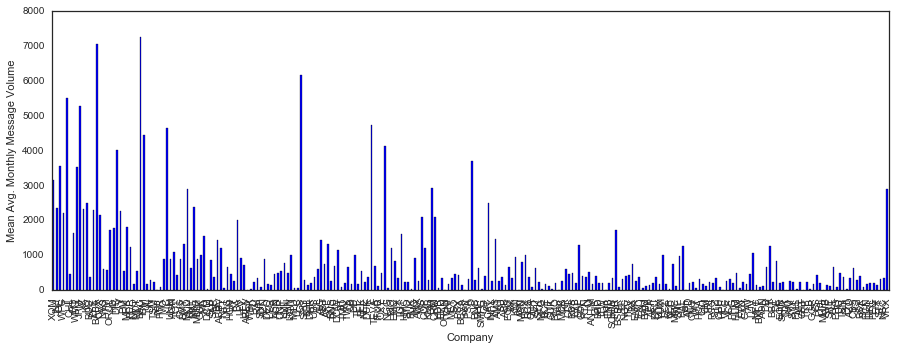

In [15]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(111)
data_nasdaq_top_250_mkt_cap_symbology['mean_avg_monthly'].plot(kind='bar')
ax.set_xticklabels(data_nasdaq_top_250_mkt_cap_symbology['symbol'], rotation=90)
plt.ylabel('Mean Avg. Monthly Message Volume')
plt.xlabel('Company')
plt.show()

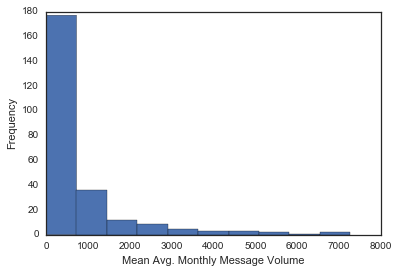

In [16]:
data_nasdaq_top_250_mkt_cap_symbology.hist(column=['mean_avg_monthly'], grid=False)
plt.ylabel('Frequency')
plt.xlabel('Mean Avg. Monthly Message Volume')
plt.title('')

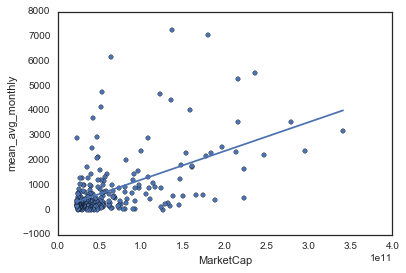

In [57]:
sentisignal.plot_scatter_regression(data_nasdaq_top_250_mkt_cap_symbology, 'MarketCap', 'mean_avg_monthly')
plt.savefig('mkt_cap_fit')

## Pull sentiment and finance data

In [18]:
data_nasdaq_top_250_sentiment = sentisignal.subsample_data(data_primary_path, data_symbology_path, data_pickles_path, start_date, end_date, 'SYMBOL', data_nasdaq_top_250_mkt_cap_symbols, False)

Loaded from pre-created pickle


In [19]:
data_nasdaq_top_250_finance = sentisignal.get_data_finance('google', data_nasdaq_top_250_mkt_cap_symbols, start_date, end_date, data_pickles_path, False, 'NaN')

Loaded from pre-created pickle


In [20]:
# preprocess creating additional statistics 
[data_nasdaq_top_250_sentiment_preprocessed, data_nasdaq_top_250_finance_preprocessed] = sentisignal.preprocess_per_symbol(data_nasdaq_top_250_sentiment, data_nasdaq_top_250_finance)

In [21]:
data_nasdaq_top_250_preprocessed_merge = sentisignal.merge_sentiment_finance(data_nasdaq_top_250_sentiment_preprocessed, data_nasdaq_top_250_finance_preprocessed, True, True, True)

In [22]:
data_nasdaq_top_250_preprocessed_merge.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
BULLISH_INTENSITY,208923,1.314987,0.979056,0.000000e+00,0.000000,1.680000,2.100000,3.890000e+00
BEARISH_INTENSITY,208923,0.847931,1.029480,0.000000e+00,0.000000,0.000000,1.850000,4.000000e+00
BULL_MINUS_BEAR,208923,0.467056,1.261379,-4.000000e+00,-0.080000,0.020000,1.580000,3.890000e+00
BULL_SCORED_MESSAGES,208923,6.133877,24.326479,0.000000e+00,0.000000,2.000000,5.000000,4.468000e+03
BEAR_SCORED_MESSAGES,208923,2.440861,13.481800,0.000000e+00,0.000000,0.000000,2.000000,1.922000e+03
BULL_BEAR_MSG_RATIO,208923,1.310469,5.119176,0.000000e+00,0.000000,0.000000,1.460000,1.472000e+03
TOTAL_SCANNED_MESSAGES,208923,41.918736,146.004999,1.000000e+00,5.000000,13.000000,36.000000,2.954200e+04
LOG_BULL_RETURN,208923,0.116392,0.913597,-5.987707e+00,-0.453120,0.000000,0.693147,6.680855e+00
LOG_BEAR_RETURN,208923,0.076346,0.768334,-5.017280e+00,0.000000,0.000000,0.559616,5.921578e+00
LOG_BULLISHNESS,208923,0.539578,0.861436,-4.916325e+00,0.000000,0.538997,1.098612,7.090910e+00


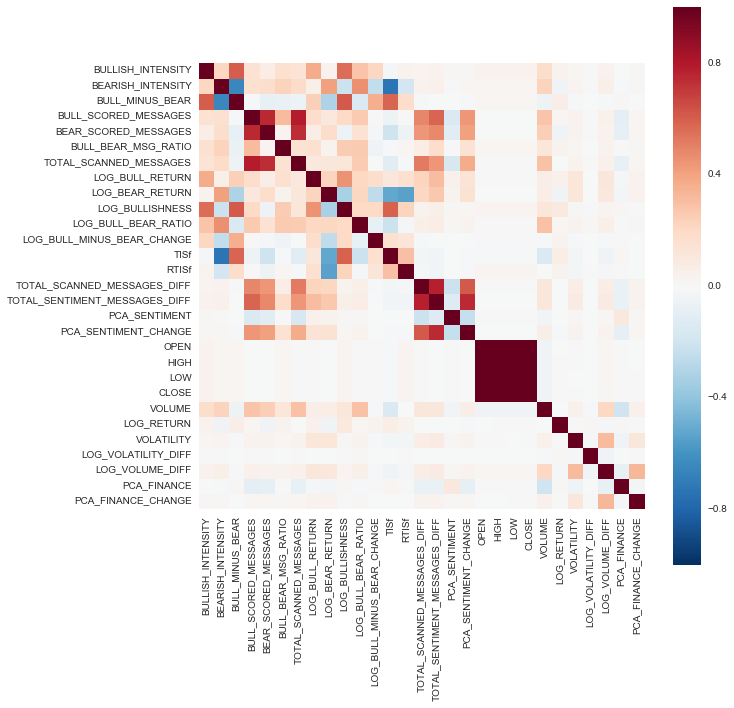

In [23]:
sentisignal.plot_corr(data_nasdaq_top_250_preprocessed_merge)

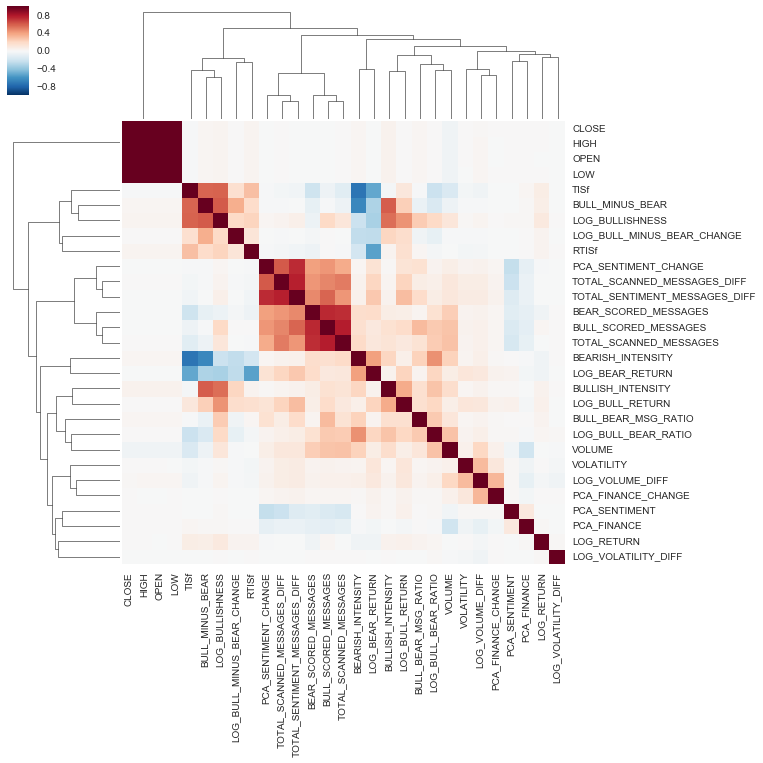

In [24]:
sentisignal.plot_clustermap(data_nasdaq_top_250_preprocessed_merge)

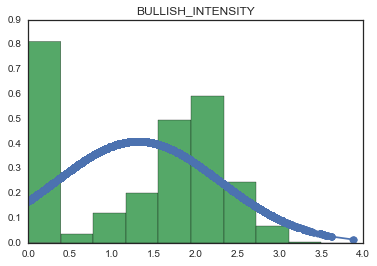

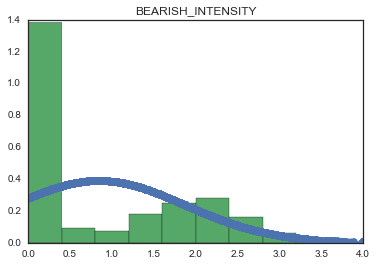

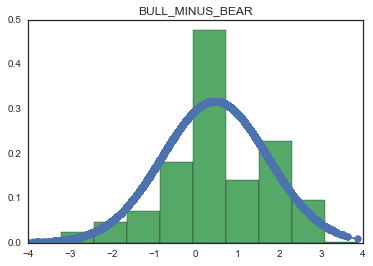

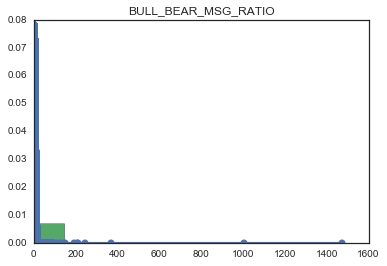

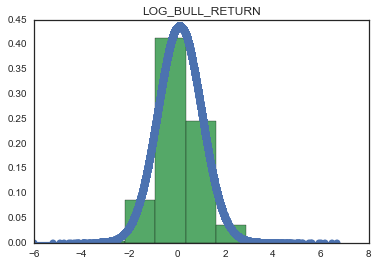

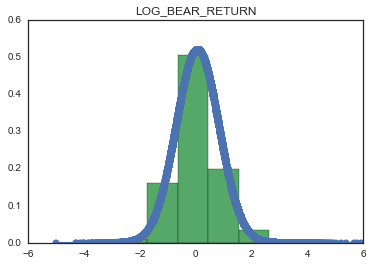

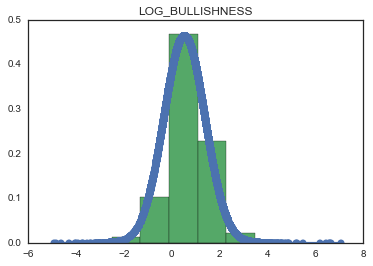

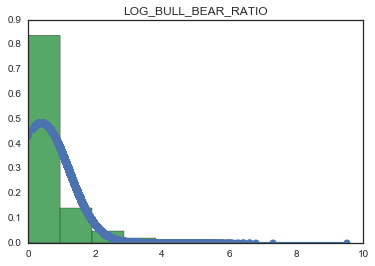

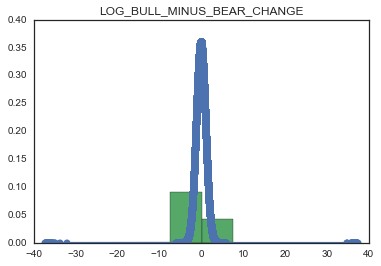

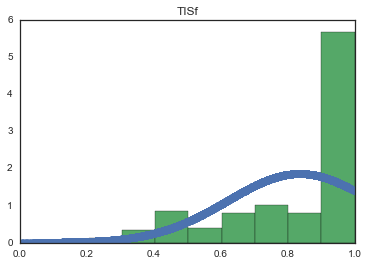

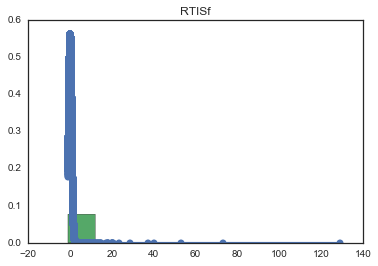

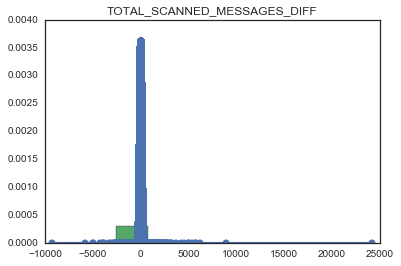

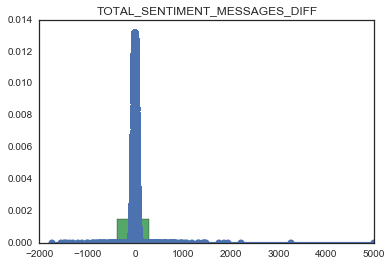

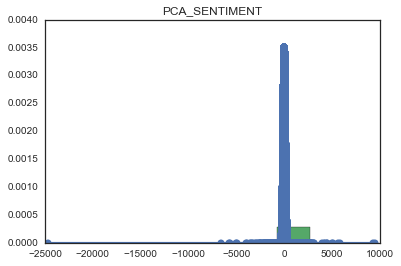

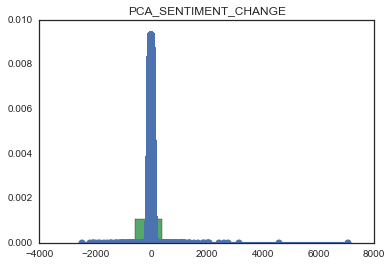

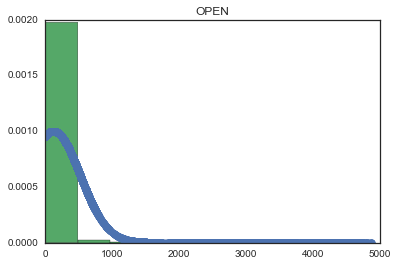

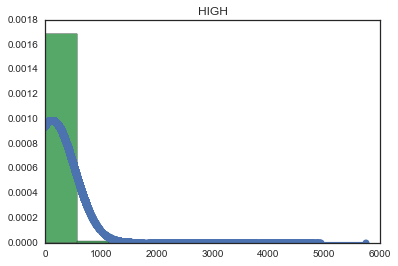

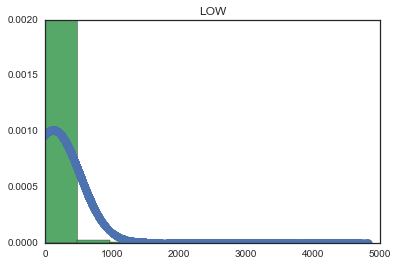

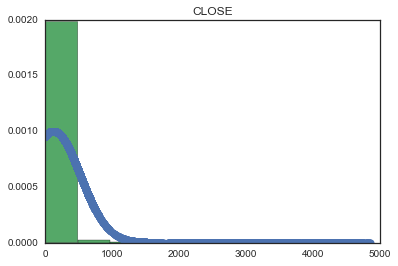

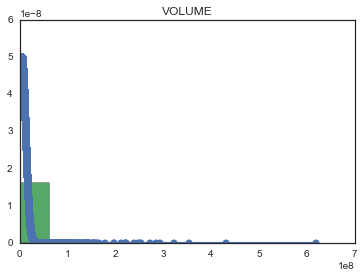

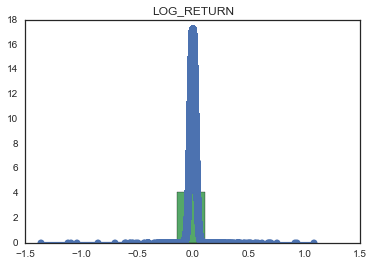

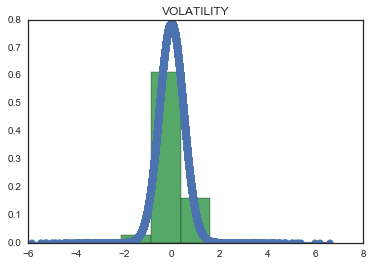

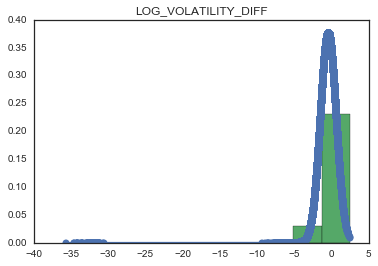

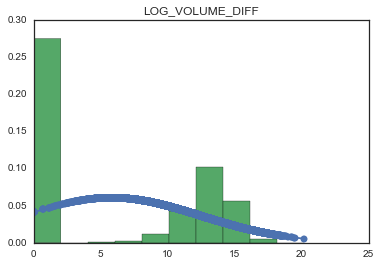

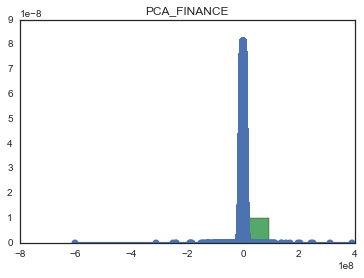

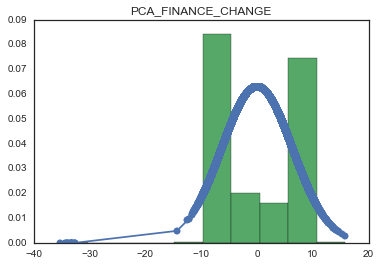

In [25]:
sentisignal.check_pdf(data_nasdaq_top_250_preprocessed_merge)

C:\Users\Derek\Desktop\Python\Z\lib\site-packages\matplotlib\pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


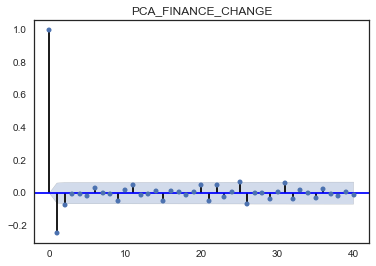

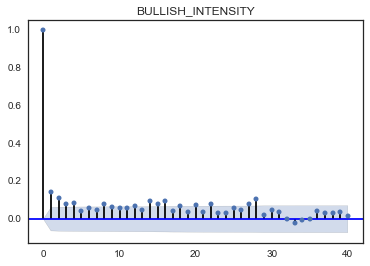

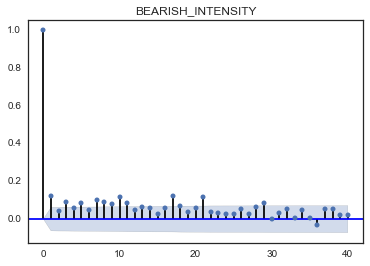

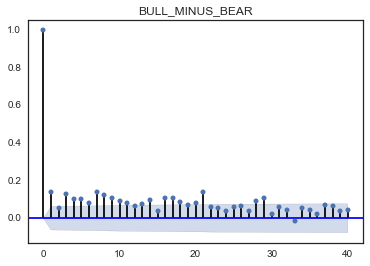

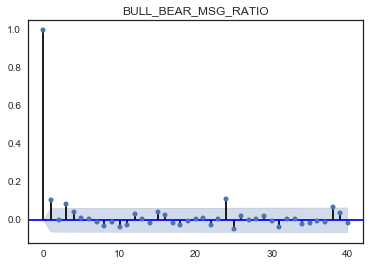

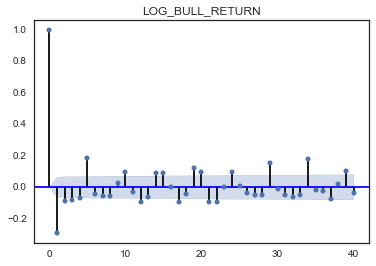

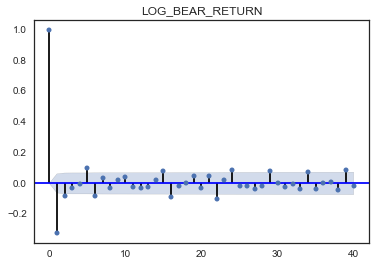

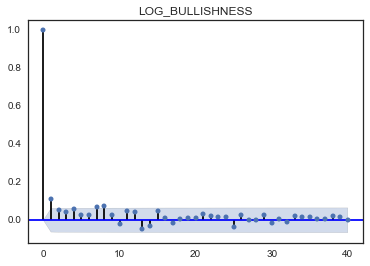

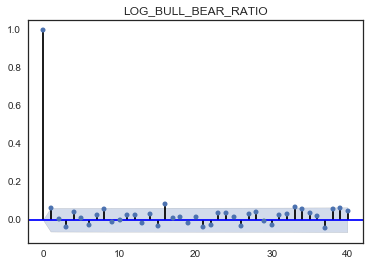

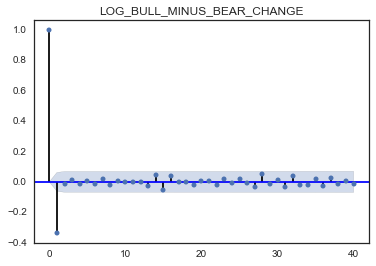

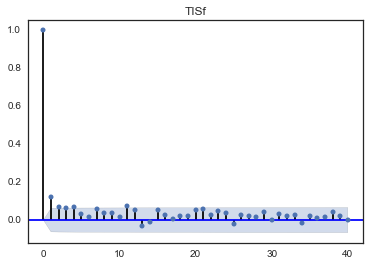

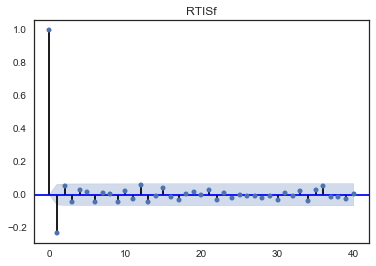

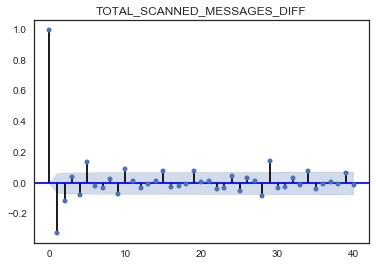

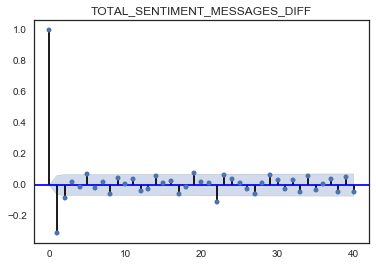

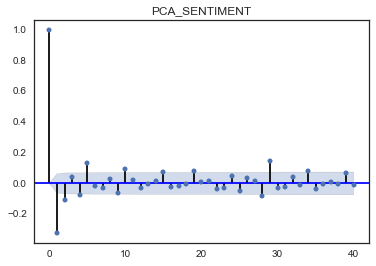

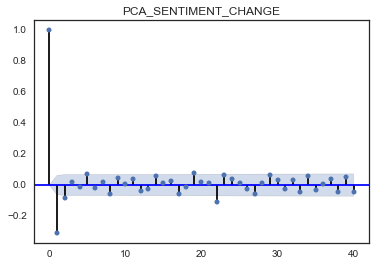

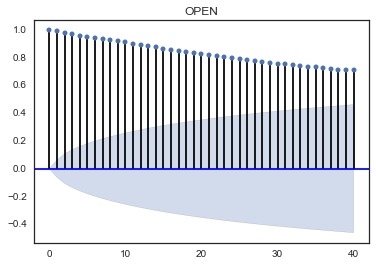

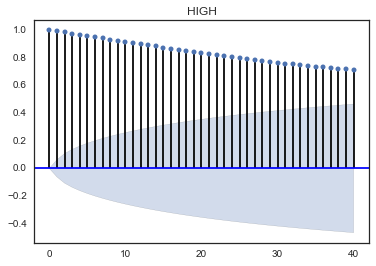

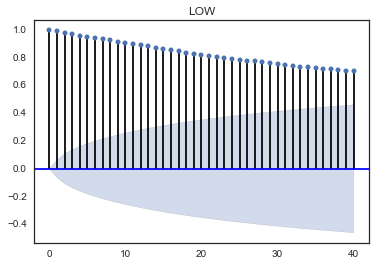

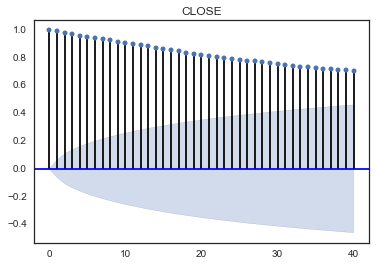

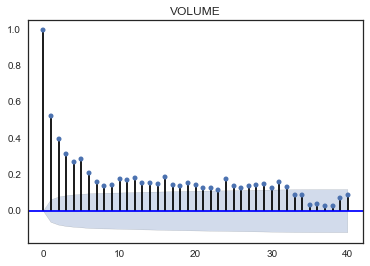

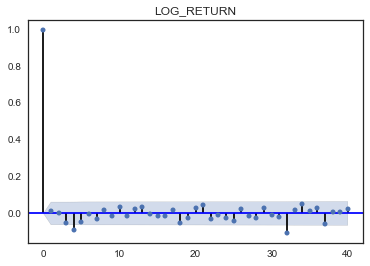

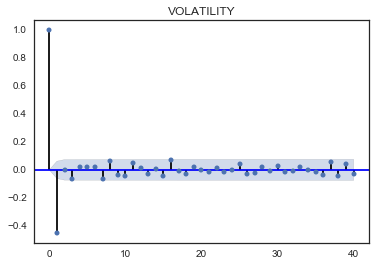

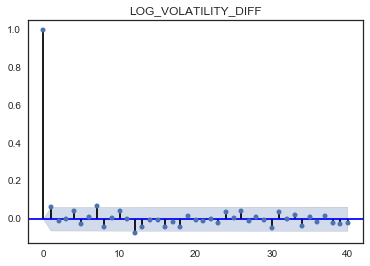

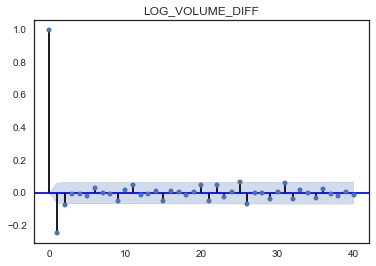

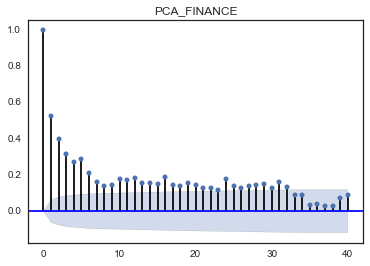

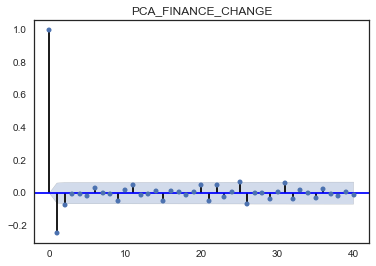

In [26]:
sentisignal.check_acf(data_nasdaq_top_250_preprocessed_merge[data_nasdaq_top_250_preprocessed_merge.SYMBOL == 'XOM'])

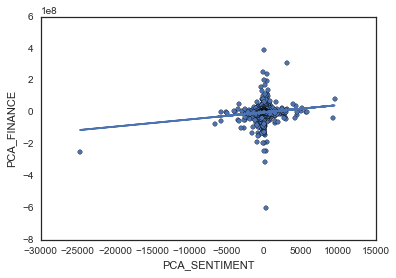

In [27]:
sentisignal.plot_scatter_regression(data_nasdaq_top_250_preprocessed_merge, 'PCA_SENTIMENT', 'PCA_FINANCE')

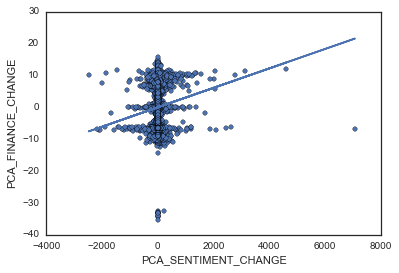

In [28]:
sentisignal.plot_scatter_regression(data_nasdaq_top_250_preprocessed_merge, 'PCA_SENTIMENT_CHANGE', 'PCA_FINANCE_CHANGE')

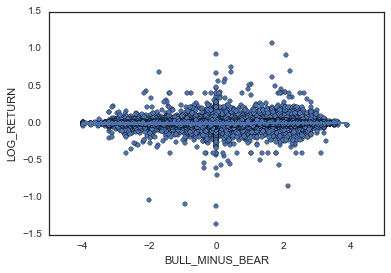

In [29]:
sentisignal.plot_scatter_regression(data_nasdaq_top_250_preprocessed_merge, 'BULL_MINUS_BEAR', 'LOG_RETURN')

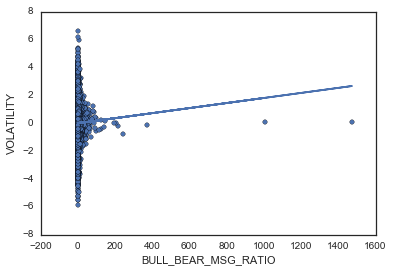

In [30]:
sentisignal.plot_scatter_regression(data_nasdaq_top_250_preprocessed_merge, 'BULL_BEAR_MSG_RATIO', 'VOLATILITY')
plt.savefig('BBMR_VOL_Regression')

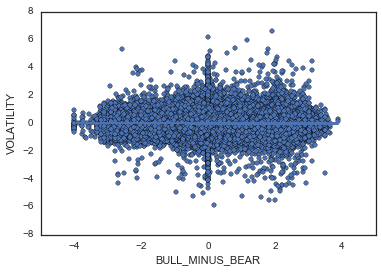

In [31]:
sentisignal.plot_scatter_regression(data_nasdaq_top_250_preprocessed_merge, 'BULL_MINUS_BEAR', 'VOLATILITY')
plt.savefig('BMB_VOL_Regression')

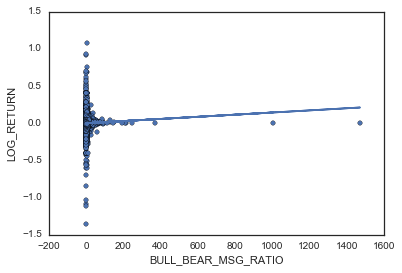

In [32]:
sentisignal.plot_scatter_regression(data_nasdaq_top_250_preprocessed_merge, 'BULL_BEAR_MSG_RATIO', 'LOG_RETURN')
plt.savefig('BBMR_LR_Regression')

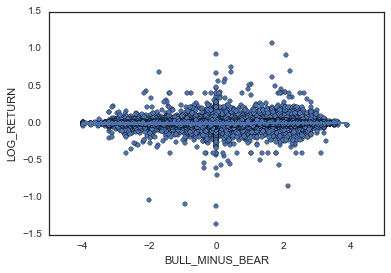

In [33]:
sentisignal.plot_scatter_regression(data_nasdaq_top_250_preprocessed_merge, 'BULL_MINUS_BEAR', 'LOG_RETURN')
plt.savefig('BMB_LR_Regression')

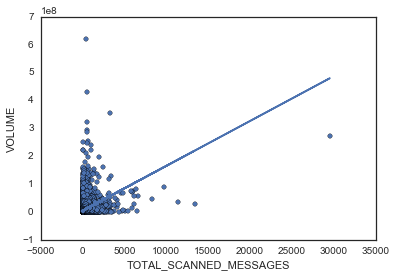

In [34]:
sentisignal.plot_scatter_regression(data_nasdaq_top_250_preprocessed_merge, 'TOTAL_SCANNED_MESSAGES', 'VOLUME')

In [35]:
data_nasdaq_top_250_preprocessed_merge.to_pickle(data_pickles_path+'intermediate/'+'data_nasdaq_top_250_preprocessed_merge_'+start_date+'_'+end_date)

In [36]:
data_nasdaq_top_250_preprocessed_merge_window_30 = sentisignal.split_apply_combine(data_nasdaq_top_250_preprocessed_merge, 'SYMBOL', sentisignal.apply_rolling_window, 30)

In [37]:
data_nasdaq_top_250_preprocessed_merge_window_30.describe()

,BULL_SCORED_MESSAGES,BEAR_SCORED_MESSAGES,TOTAL_SCANNED_MESSAGES,BULLISH_INTENSITY,BEARISH_INTENSITY,BULL_MINUS_BEAR,BULL_BEAR_MSG_RATIO,LOG_BULL_RETURN,LOG_BEAR_RETURN,LOG_BULLISHNESS,...,HIGH,LOW,CLOSE,VOLUME,LOG_RETURN,VOLATILITY,LOG_VOLATILITY_DIFF,LOG_VOLUME_DIFF,PCA_FINANCE,PCA_FINANCE_CHANGE
count,208922.000000,208922.000000,208922.000000,208922.000000,208922.000000,208922.000000,208922.000000,208922.000000,2.089220e+05,208922.000000,...,208922.000000,208922.000000,208922.000000,2.089220e+05,208922.000000,2.089220e+05,208922.000000,208922.000000,2.089220e+05,208922.000000
mean,6.133887,2.440873,41.918912,1.305735,0.840452,0.465283,1.292530,0.117081,7.604174e-02,0.533795,...,128.437798,125.952043,129.396602,4.681028e+06,0.000353,5.929891e-04,-0.387977,5.806724,-2.695965e+04,0.005672
std,24.326537,13.481832,146.005326,0.490457,0.533888,0.366530,1.642899,0.117615,9.911973e-02,0.352972,...,402.969053,394.254036,398.742733,6.926133e+06,0.003682,3.771899e-02,0.244784,1.988966,2.784554e+06,0.870106
min,0.000000,0.000000,1.000000,0.000000,0.000000,-3.200000,0.000000,-1.992430,-2.944439e+00,-1.609438,...,0.000000,0.000000,0.013000,0.000000e+00,-0.156083,-2.302585e+00,-8.160614,0.000000,-2.521219e+08,-9.132136
25%,0.000000,0.000000,5.000000,0.930000,0.401000,0.209000,0.211000,0.034055,3.700743e-17,0.265518,...,30.246917,29.779833,31.203333,8.539703e+05,-0.001108,-1.375108e-02,-0.515052,5.473986,-3.421785e+05,-0.489015
50%,2.000000,0.000000,13.000000,1.360333,0.745000,0.453667,0.711667,0.103784,5.228720e-02,0.488232,...,52.604500,51.711500,53.483000,2.556716e+06,0.000470,2.891206e-19,-0.382488,6.265753,9.072907e+03,-0.013319
75%,5.000000,2.000000,36.000000,1.741333,1.240667,0.708667,1.960333,0.188351,1.203639e-01,0.762001,...,85.474000,84.090417,86.898000,5.561939e+06,0.001987,1.487624e-02,-0.251173,6.947038,4.063940e+05,0.493432
max,4468.000000,1922.000000,29542.000000,3.110000,3.200000,3.110000,54.343667,3.555348,2.772589e+00,3.258097,...,4797.557667,4691.674333,4745.800000,2.718794e+08,0.103752,2.166170e+00,1.529747,17.464009,9.534642e+07,11.286690


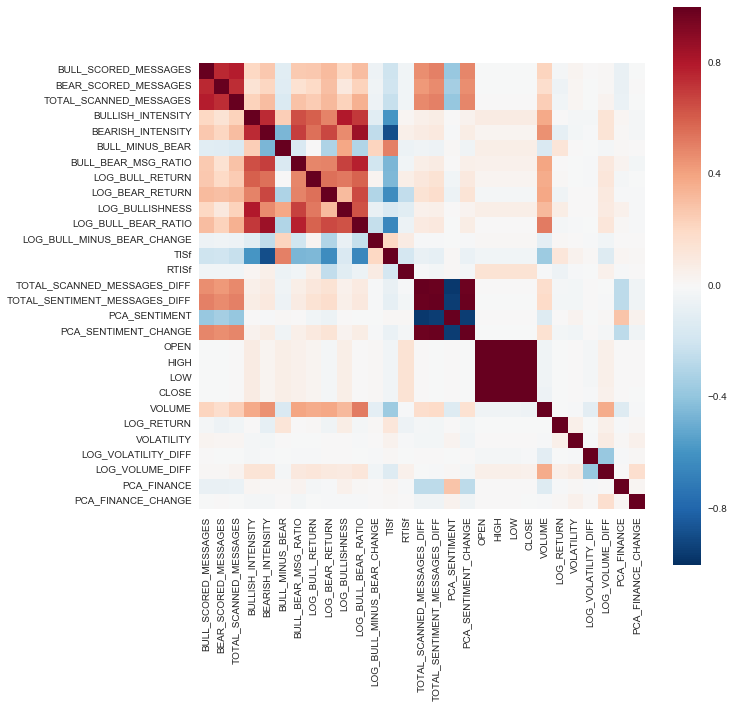

In [38]:
sentisignal.plot_corr(data_nasdaq_top_250_preprocessed_merge_window_30)

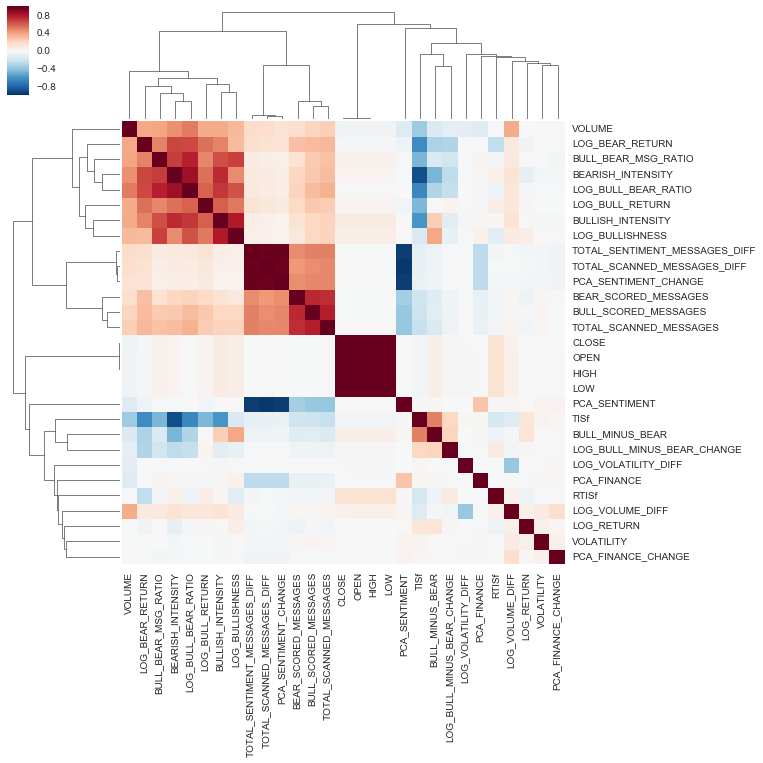

In [39]:
sentisignal.plot_clustermap(data_nasdaq_top_250_preprocessed_merge_window_30)

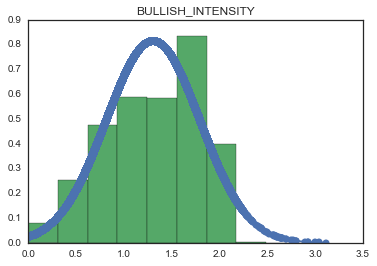

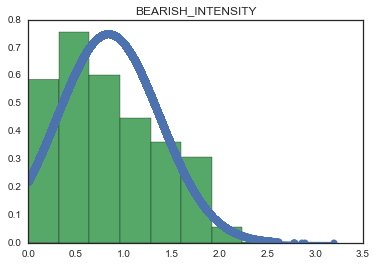

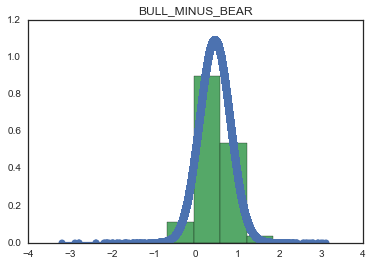

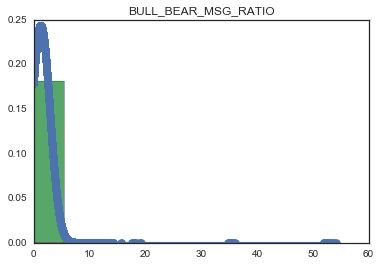

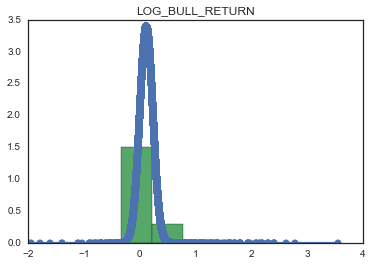

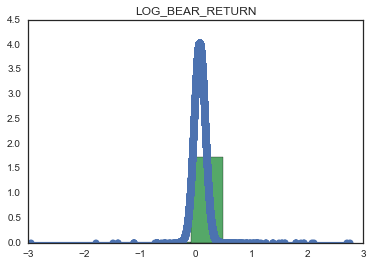

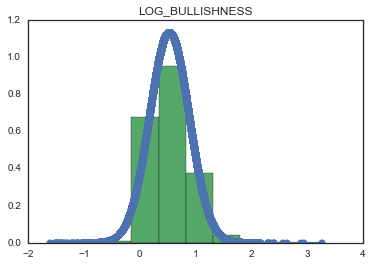

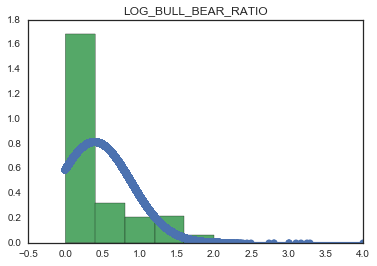

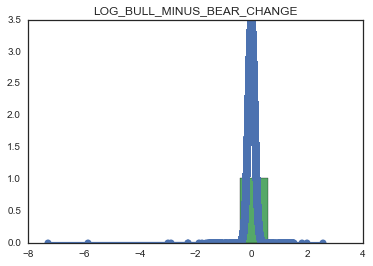

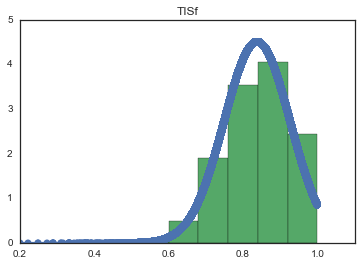

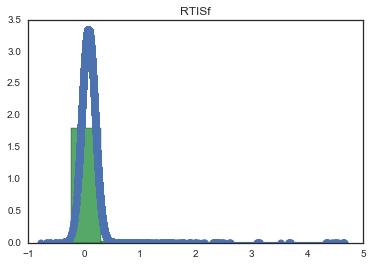

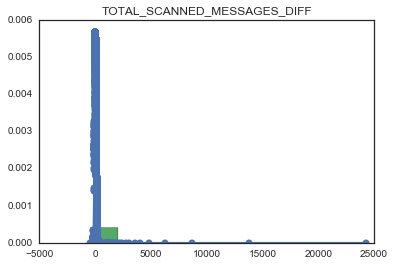

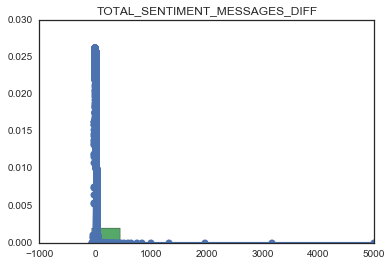

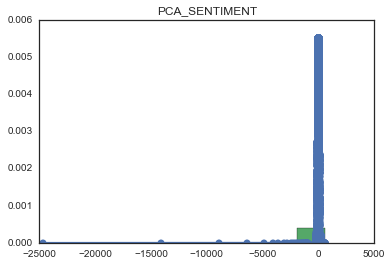

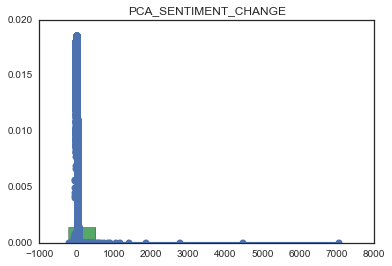

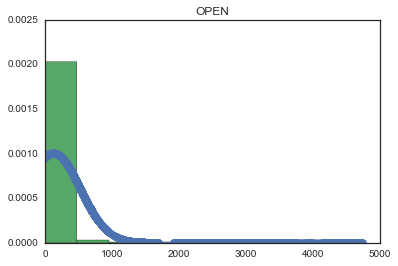

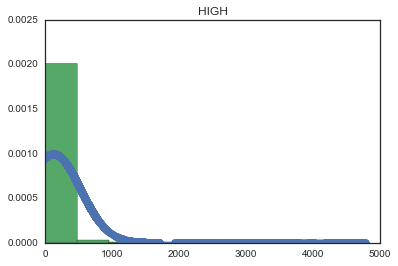

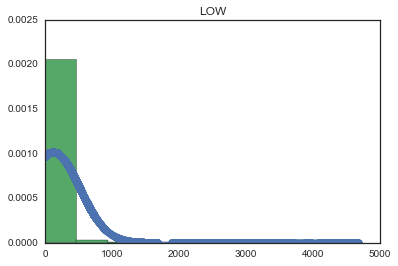

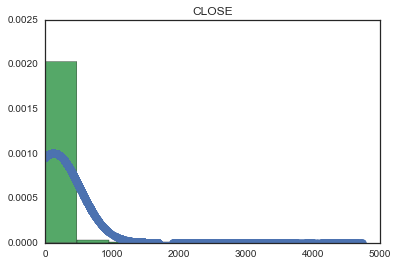

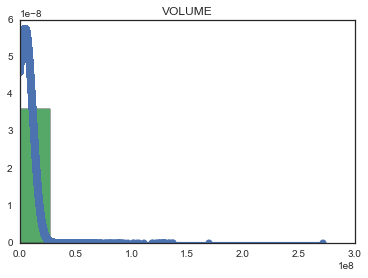

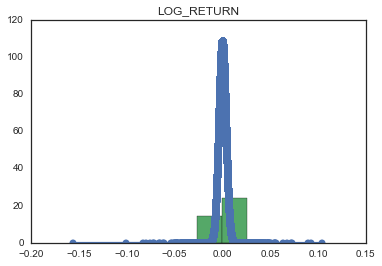

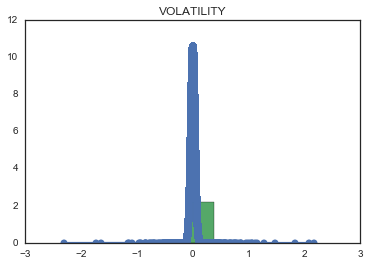

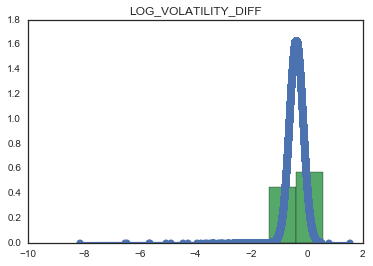

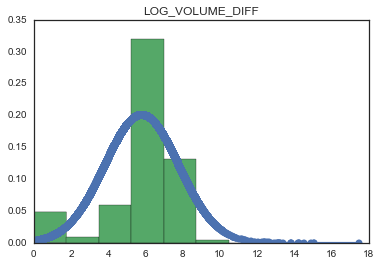

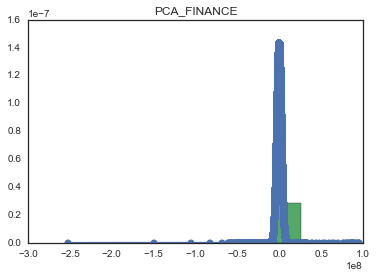

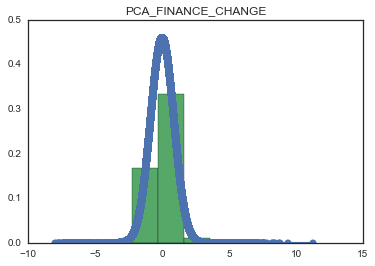

In [40]:
sentisignal.check_pdf(data_nasdaq_top_250_preprocessed_merge_window_30)

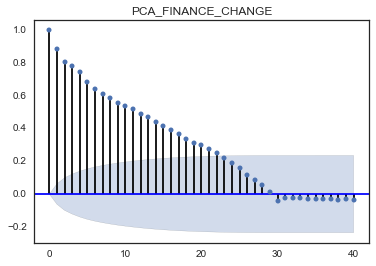

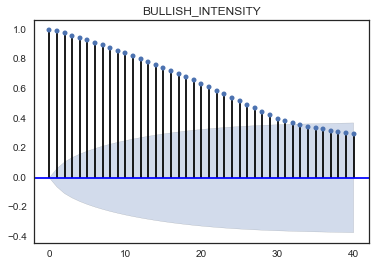

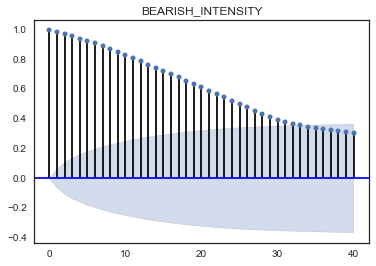

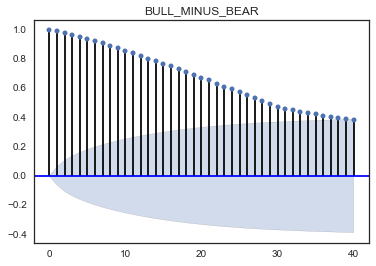

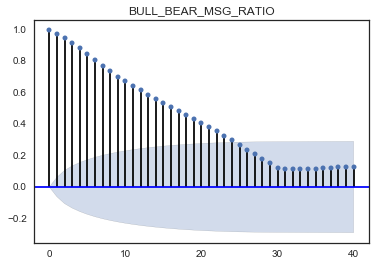

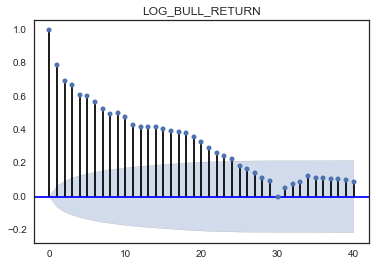

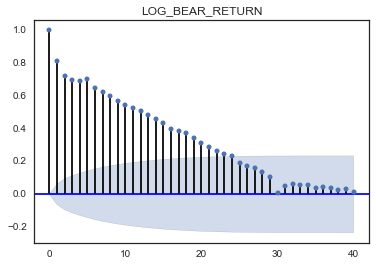

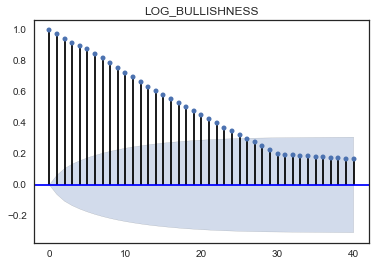

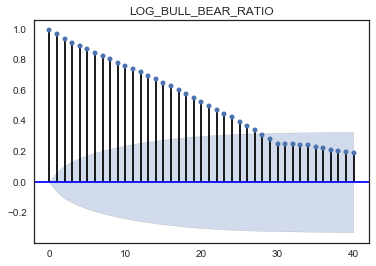

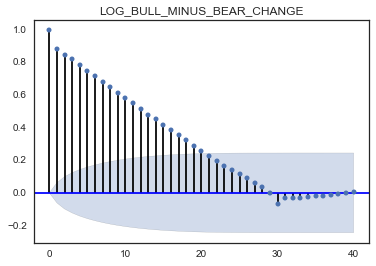

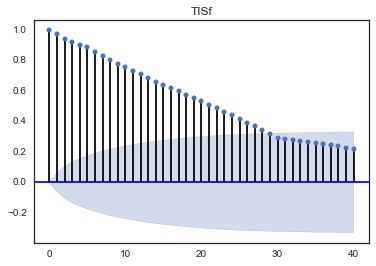

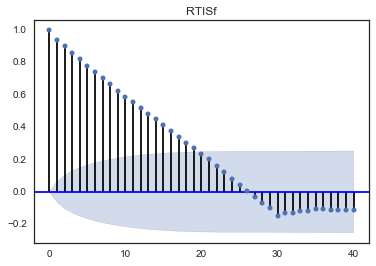

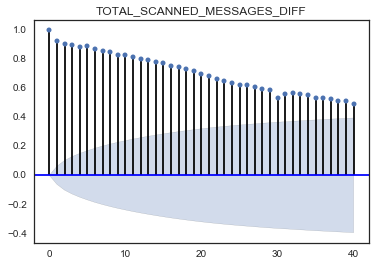

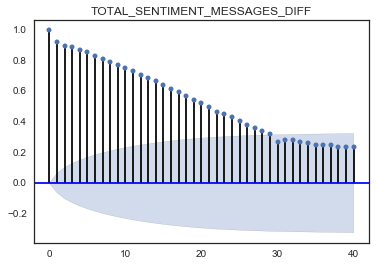

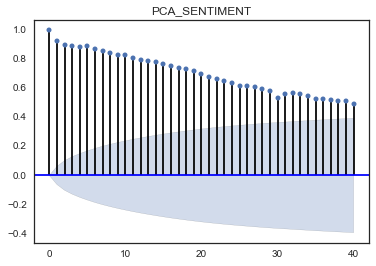

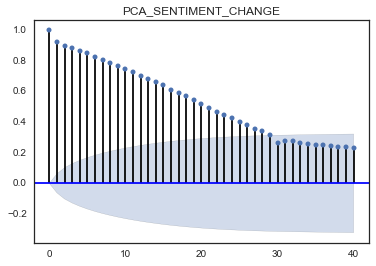

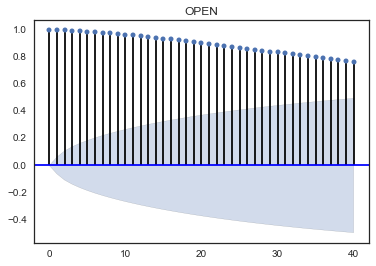

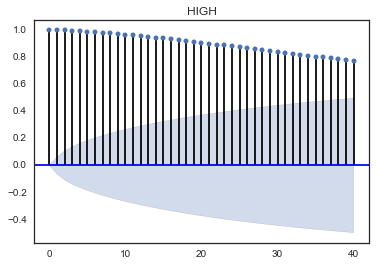

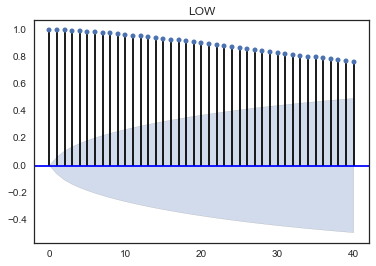

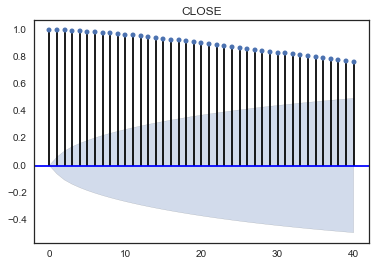

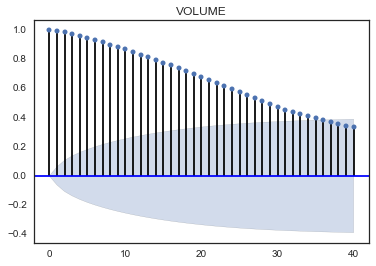

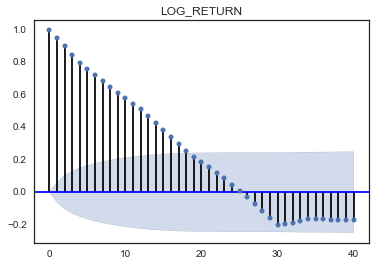

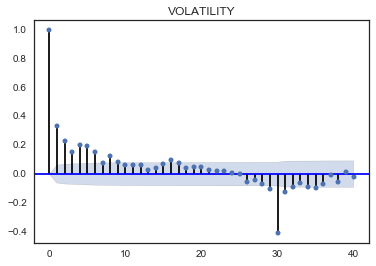

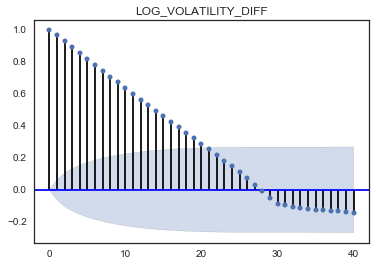

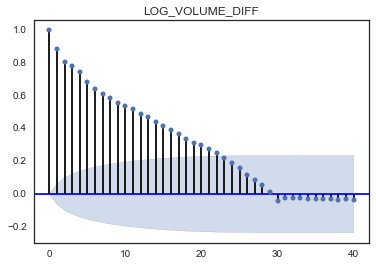

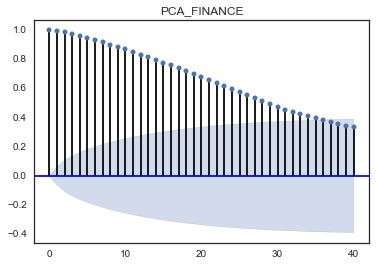

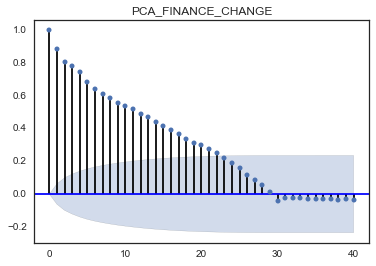

In [41]:
sentisignal.check_acf(data_nasdaq_top_250_preprocessed_merge_window_30[data_nasdaq_top_250_preprocessed_merge_window_30.SYMBOL == 'XOM'])

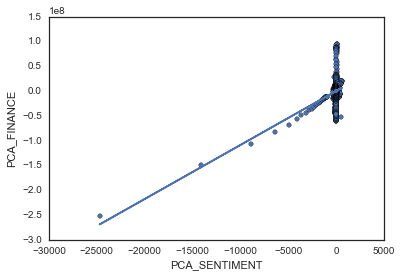

In [42]:
sentisignal.plot_scatter_regression(data_nasdaq_top_250_preprocessed_merge_window_30, 'PCA_SENTIMENT', 'PCA_FINANCE')

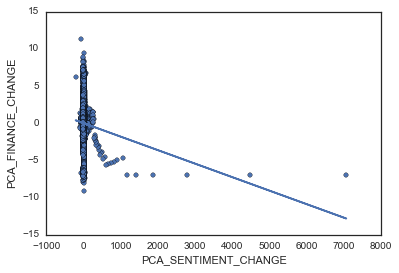

In [43]:
sentisignal.plot_scatter_regression(data_nasdaq_top_250_preprocessed_merge_window_30, 'PCA_SENTIMENT_CHANGE', 'PCA_FINANCE_CHANGE')

In [44]:
data_nasdaq_top_250_preprocessed_merge_window_30.to_pickle(data_pickles_path+'intermediate/'+'data_nasdaq_top_250_preprocessed_merge_'+start_date+'_'+end_date+'_window_'+str(30))

In [45]:
data_nasdaq_top_250_preprocessed_merge_window_10 = sentisignal.split_apply_combine(data_nasdaq_top_250_preprocessed_merge, 'SYMBOL', sentisignal.apply_rolling_window, 10)

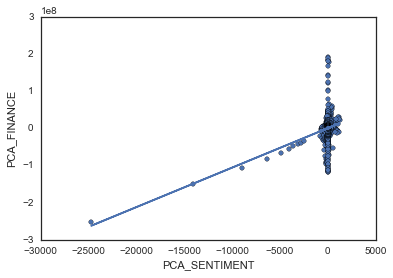

In [46]:
sentisignal.plot_scatter_regression(data_nasdaq_top_250_preprocessed_merge_window_10, 'PCA_SENTIMENT', 'PCA_FINANCE')

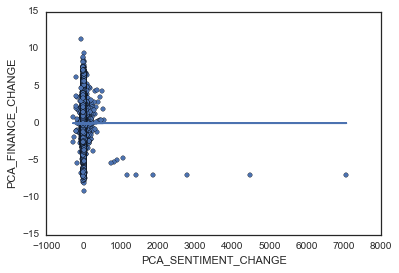

In [47]:
sentisignal.plot_scatter_regression(data_nasdaq_top_250_preprocessed_merge_window_10, 'PCA_SENTIMENT_CHANGE', 'PCA_FINANCE_CHANGE')

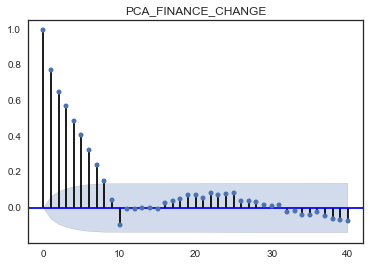

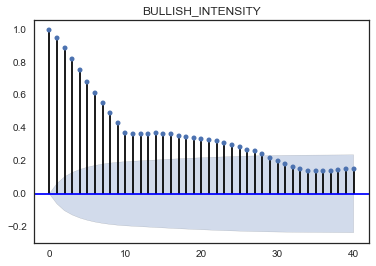

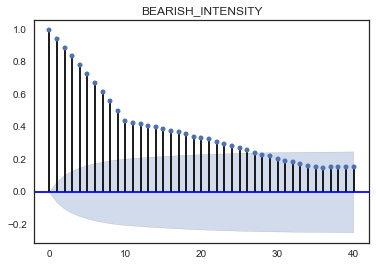

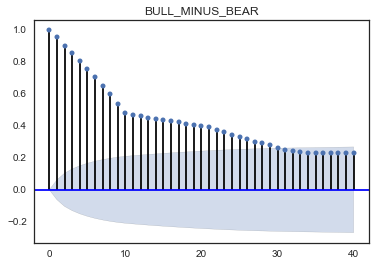

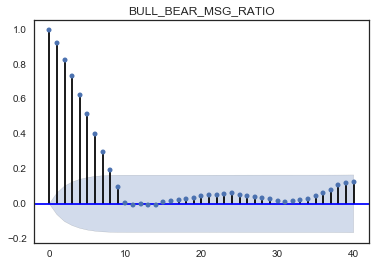

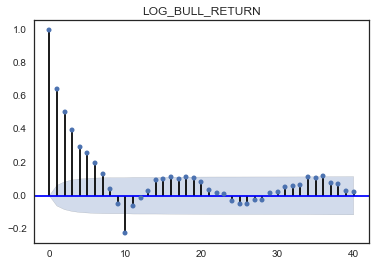

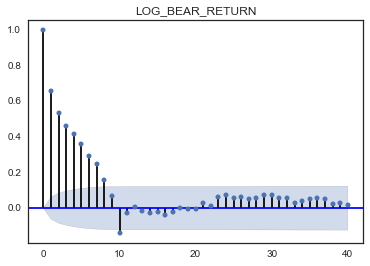

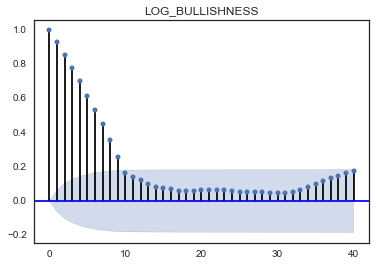

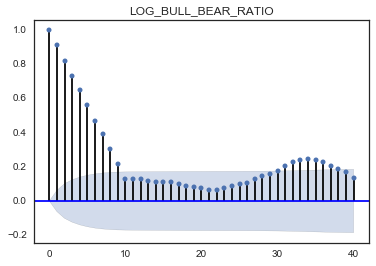

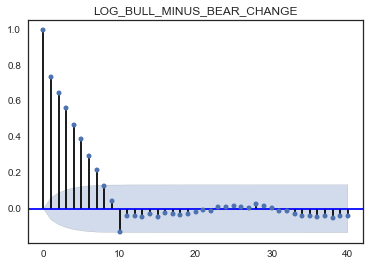

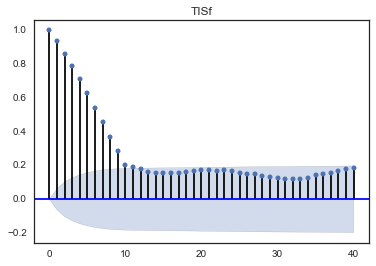

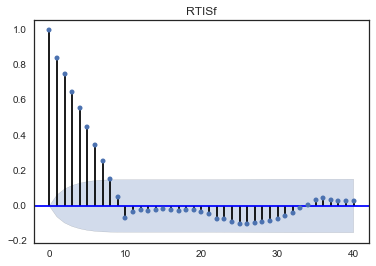

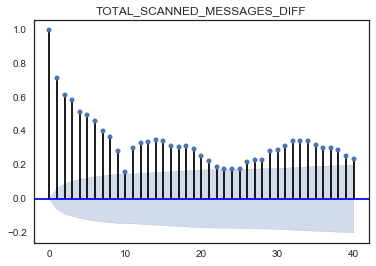

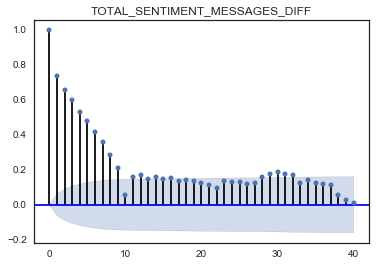

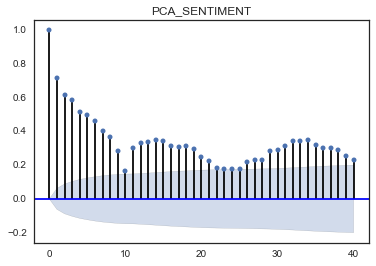

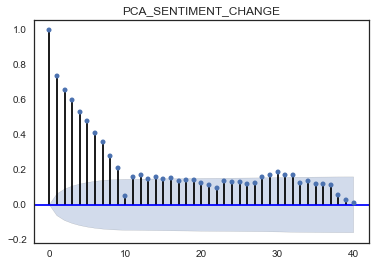

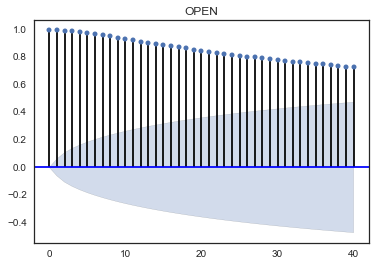

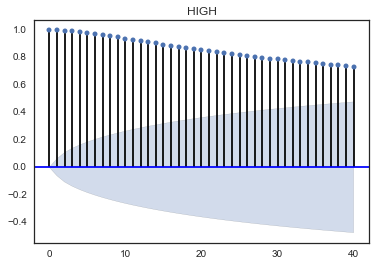

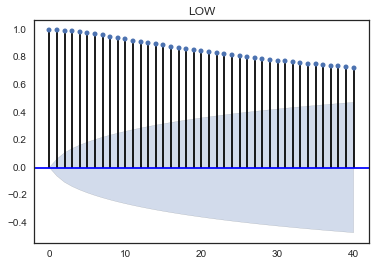

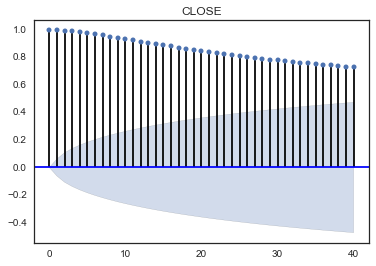

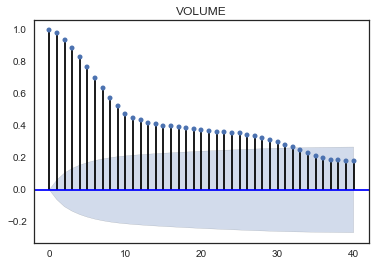

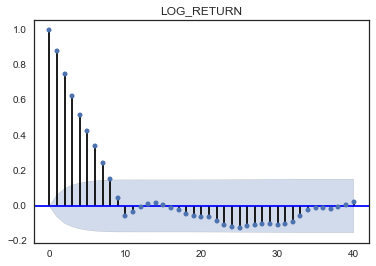

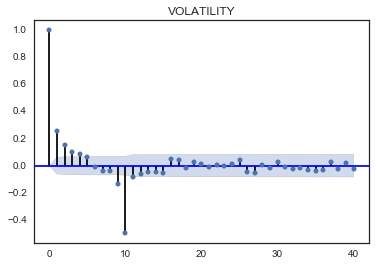

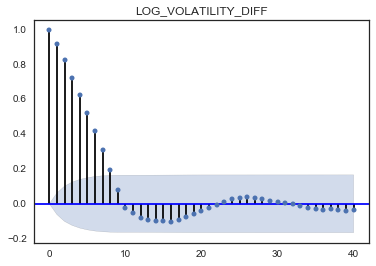

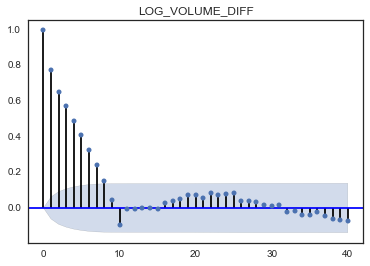

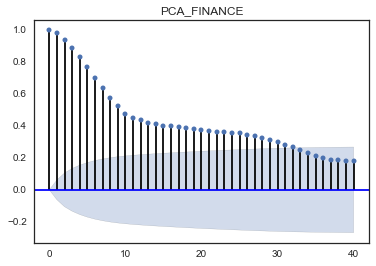

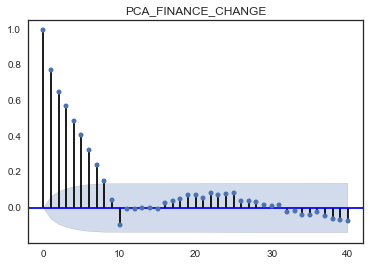

In [48]:
sentisignal.check_acf(data_nasdaq_top_250_preprocessed_merge_window_10[data_nasdaq_top_250_preprocessed_merge_window_10.SYMBOL == 'XOM'])

In [49]:
data_nasdaq_top_250_preprocessed_merge_window_10.to_pickle(data_pickles_path+'intermediate/'+'data_nasdaq_top_250_preprocessed_merge_'+start_date+'_'+end_date+'_window_'+str(10))

# Part 2: MI and Clustering

In [128]:
data_primary_path = '../../data/csv/stocktwits_twitter_withretweets_daily.csv'
data_symbology_path = '../../data/csv/symbology.csv'
data_pickles_path = '../../data/pickles/'
data_nasdaq_company_list_path = '../../data/csv/NYSE.csv'
start_date = '2012-01-01'
end_date = '2016-01-01'

data_symbology = pd.read_csv(data_symbology_path)


data_nasdaq_company_list = pd.read_csv(data_nasdaq_company_list_path)
data_nasdaq_top_250_mkt_cap = data_nasdaq_company_list.head(250)
data_nasdaq_top_250_mkt_cap_symbols = data_nasdaq_top_250_mkt_cap['Symbol'].unique()

In [129]:
data_nasdaq_top_250_preprocessed_merge = pd.read_pickle(data_pickles_path+'intermediate/'+'data_nasdaq_top_250_preprocessed_merge_'+start_date+'_'+end_date)

In [130]:
ata_nasdaq_top_250_preprocessed_merge_window_30 = pd.read_pickle(data_pickles_path+'intermediate/'+'data_nasdaq_top_250_preprocessed_merge_'+start_date+'_'+end_date+'_window_30')
data_nasdaq_top_250_preprocessed_merge_window_10 = pd.read_pickle(data_pickles_path+'intermediate/'+'data_nasdaq_top_250_preprocessed_merge_'+start_date+'_'+end_date+'_window_10')

In [131]:
print "Minimum time series length: ", data_nasdaq_top_250_preprocessed_merge.groupby(['SYMBOL']).apply(len).min()
print "Maximum time series length: ", data_nasdaq_top_250_preprocessed_merge.groupby(['SYMBOL']).apply(len).max()

Minimum time series length:  17
Maximum time series length:  1008


In [55]:
## ex-ante
merge_mi_res = sentisignal.split_apply_combine(data_nasdaq_top_250_preprocessed_merge, 'SYMBOL', sentisignal.information_surplus, 10, 'PCA_SENTIMENT', 'LOG_RETURN', -1, True)
# ex-post
merge_mi_res_validate = sentisignal.split_apply_combine(data_nasdaq_top_250_preprocessed_merge, 'SYMBOL', sentisignal.information_surplus, 10, 'PCA_SENTIMENT', 'LOG_RETURN', -1, False)

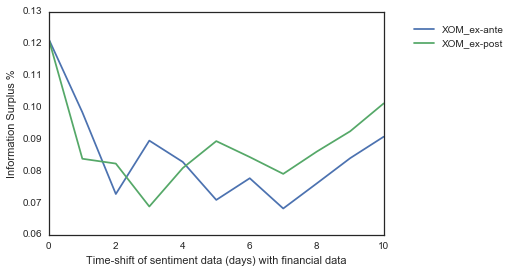

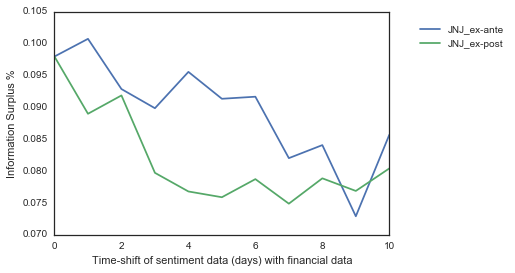

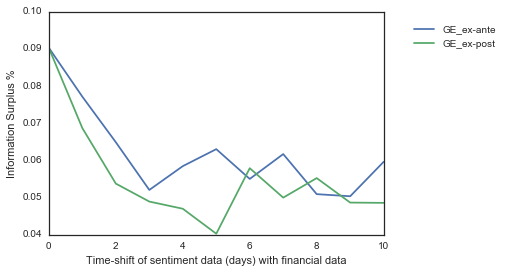

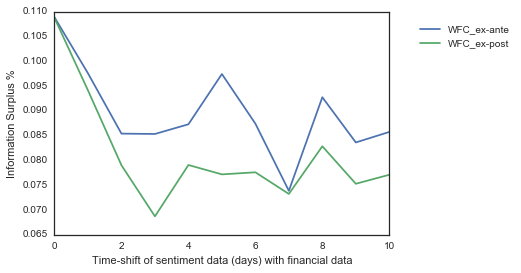

In [56]:
sentisignal.plot_lead_trail_res(merge_mi_res, merge_mi_res_validate, ['XOM'])
plt.savefig('XOM_lr.png')
sentisignal.plot_lead_trail_res(merge_mi_res, merge_mi_res_validate, ['JNJ'])
plt.savefig('JNJ_lr.png')
sentisignal.plot_lead_trail_res(merge_mi_res, merge_mi_res_validate, ['GE'])
plt.savefig('GE_lr.png')
sentisignal.plot_lead_trail_res(merge_mi_res, merge_mi_res_validate, ['WFC'])
plt.savefig('WFC.lr.png')

length prior to constrain 238
length after to constrain 97
ABB
ABEV
AEP
AGN
ANTM
AV
AXP
BBD
BBL
BBVA
BCS
BHP
BK
BMO
BMY
BNS
BSBR
BT
BUD
BX
BXLT
CAT
CB
CHL
CM
COP
CUK
D
DAL
DIS
DUK
E
ECL
EIX
EMR
EOG
EQR
FMS
GE
GGP
GS
HDB
HON
HPE
HUM
IBM
ING
JNJ
JPM
K
KEP
LB
LFC
LUX
MCK
MET
MFG
MMC
MRK
MS
MTU
NKE
NOC
ORAN
ORCL
PFE
PHG
PHI
PPG
PRU
PSA
PTR
PUK
RBS
RIO
RTN
RY
SAN
SMFG
SNY
SRE
STO
SU
SYF
SYT
T
TD
TEF
TLK
TM
TOT
TRI
TRP
TRV
UBS
UL
UN
length after to test 97


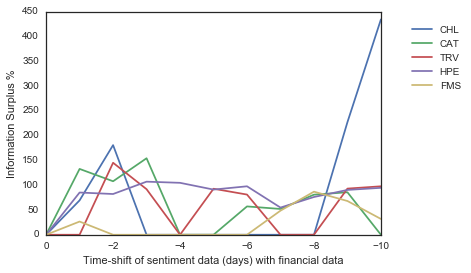

In [62]:
merge_net_mi_res = sentisignal.split_apply_combine(data_nasdaq_top_250_preprocessed_merge, 'SYMBOL', sentisignal.net_information_surplus, 10, 'PCA_SENTIMENT', 'VOLATILITY', -1)
merge_net_mi_res_constr = sentisignal.constrain_mi_res(merge_net_mi_res)
merge_net_mi_res_test = sentisignal.constrain_test_significant(merge_net_mi_res_constr, data_nasdaq_top_250_preprocessed_merge, 'PCA_SENTIMENT', 'VOLATILITY')
sentisignal.plot_inf_res(merge_net_mi_res_test, plot_top=5, time_shift=10)
to_cluster1 = merge_net_mi_res_test

length prior to constrain 238
length after to constrain 92
ABB
ABEV
AEP
AFL
ALL
AON
APD
AVB
AZO
BA
BAM
BBL
BBVA
BHP
BMO
BMY
BNS
BSBR
BT
CAJ
CAT
CB
CHA
CHL
CL
CM
COF
CUK
DAL
DEO
DIS
E
EIX
EMR
EOG
EPD
EQR
FMS
GGP
HON
HUM
IBM
ING
ITUB
ITW
JPM
KEP
LB
LFC
LUX
LYG
MFG
MHFI
MS
MTU
NEE
NTT
NVO
ORAN
PCG
PEG
PHG
PHI
PPG
PPL
PRU
PTR
PUK
RTN
RY
SAN
SMFG
SNY
SRE
STO
SU
SYF
SYT
TEF
TLK
TM
TOT
TRI
TRP
TRV
TWC
UBS
UL
UN
USB
WBK
WIT
length after to test 92


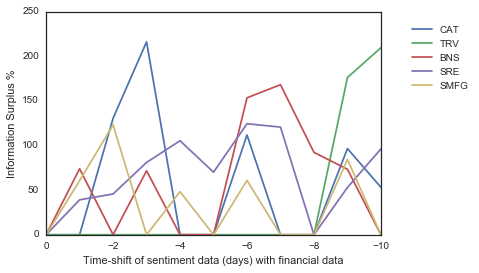

In [77]:
merge_net_mi_res = sentisignal.split_apply_combine(data_nasdaq_top_250_preprocessed_merge, 'SYMBOL', sentisignal.net_information_surplus, 10, 'PCA_SENTIMENT_CHANGE', 'VOLATILITY', -1)
merge_net_mi_res_constr = sentisignal.constrain_mi_res(merge_net_mi_res)
merge_net_mi_res_test = sentisignal.constrain_test_significant(merge_net_mi_res_constr, data_nasdaq_top_250_preprocessed_merge, 'PCA_SENTIMENT_CHANGE', 'VOLATILITY')
sentisignal.plot_inf_res(merge_net_mi_res_test, plot_top=5, time_shift=10)
to_cluster2 = merge_net_mi_res_test

In [141]:
sent_feat = ['SYMBOL', 'LOG_RETURN', 'BULL_MINUS_BEAR', 'TOTAL_SCANNED_MESSAGES', 'VOLUME', 'PCA_SENTIMENT', 'PCA_FINANCE', 'PCA_SENTIMENT_CHANGE', 'PCA_FINANCE_CHANGE', 'LOG_BULLISHNESS', 'LOG_VOLATILITY_DIFF']
nasdaq_feat =['Symbol', 'MarketCap']

cluster_list = ['MAX_MUTUAL_INFORMATION', 'AVG_INF_SURP_PCT', 'MarketCap', 'LOG_RETURN', 'BULL_MINUS_BEAR', 'TOTAL_SCANNED_MESSAGES', 'VOLUME', 'LOG_BULLISHNESS', 'POS_LAG_COUNT', 'LOG_VOLATILITY_DIFF']
attr_list = ['MAX_MUTUAL_INFORMATION', 'AVG_INF_SURP_PCT', 'POS_LAG_COUNT', 'MarketCap','BULL_MINUS_BEAR', 'TOTAL_SCANNED_MESSAGES', 'LOG_RETURN', 'VOLUME']

ValueError: Length of values does not match length of index

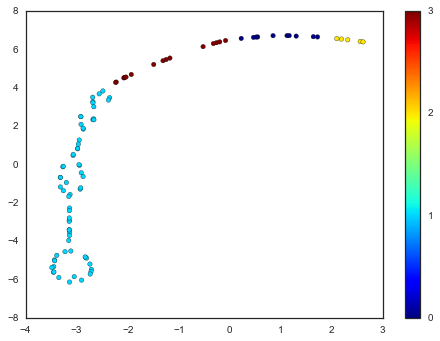

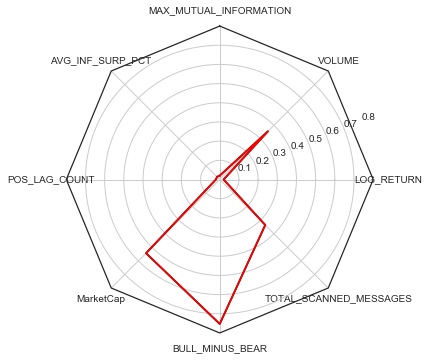

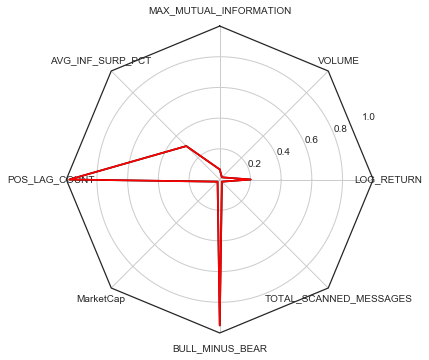

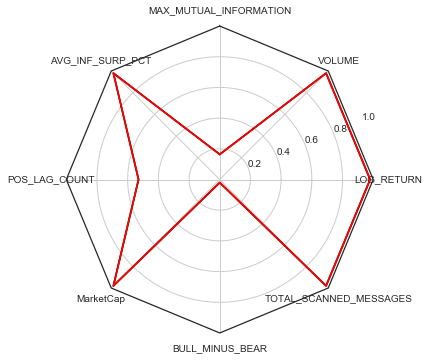

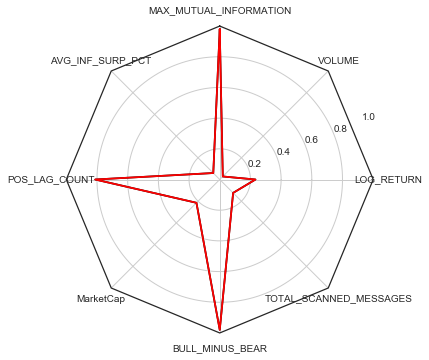

In [146]:
df = to_cluster1
res = sentisignal.prep_df_cluster(df, data_nasdaq_company_list, nasdaq_feat, data_nasdaq_top_250_preprocessed_merge, sent_feat)
gb_mean = sentisignal.kmeans(res, cluster_list, attr_list, num_clusters = 4)
#plt.savefig('Cluster.png')
#tocluster2.info()

length prior to constrain 238
length after to constrain 89
ABEV
ABT
AGN
AIG
ALL
AZO
BA
BAC
BCS
BHP
BMY
BNS
BT
BUD
BXLT
C
CHL
CHT
CNQ
COP
CVS
D
DAL
DCM
DIS
DOW
E
EMC
EMR
EOG
EPD
FMS
GS
HAL
HON
HPE
HUM
IBM
ICE
ING
ITUB
JNJ
JPM
KEP
KO
LB
LOW
LUX
LVS
MCD
MET
MFC
MFG
MHFI
MMC
MO
MS
MTU
NOC
NTT
NVS
ORAN
PEG
PFE
PHI
PNC
PPG
PRU
PUK
RIO
RTN
SAN
SLB
SNP
SO
SPG
SRE
SYF
SYY
TEF
TLK
TOT
TRP
TRV
TSM
UN
VLO
WBK
WM
length after to test 85


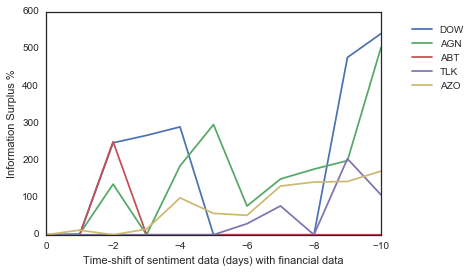

In [79]:
merge_net_mi_res = sentisignal.split_apply_combine(data_nasdaq_top_250_preprocessed_merge, 'SYMBOL', sentisignal.net_information_surplus, 10, 'PCA_SENTIMENT', 'PCA_FINANCE', -1)
merge_net_mi_res_constr = sentisignal.constrain_mi_res(merge_net_mi_res)
merge_net_mi_res_test = sentisignal.constrain_test_significant(merge_net_mi_res_constr, data_nasdaq_top_250_preprocessed_merge, 'PCA_SENTIMENT', 'PCA_FINANCE')
sentisignal.plot_inf_res(merge_net_mi_res_test, plot_top=5, time_shift=10)
to_cluster3 = merge_net_mi_res_test

length prior to constrain 238
length after to constrain 127
ABB
ABT
AEP
AGN
APD
AV
AZN
AZO
BA
BAC
BAM
BDX
BK
BLK
BNS
BSBR
BSX
BX
BXLT
CAT
CB
CCI
CCL
CHA
CHL
CHT
CI
CL
CM
COP
CUK
CVS
D
DAL
DD
DG
DIS
DOW
E
EIX
EL
EOG
EQR
FMS
GGP
GIS
GM
GS
GSK
HAL
HCN
HD
HMC
HON
HPE
HUM
IBM
ICE
ING
ITUB
JNJ
JPM
K
KEP
KMB
LFC
LOW
LYB
LYG
MCD
MCK
MDT
MET
MFC
MHFI
MTU
NKE
NVS
ORAN
PEP
PHG
PHI
PNC
PPG
PSA
PSX
PTR
PUK
PX
RAI
RTN
RY
SAN
SCHW
SMFG
SNE
SNY
SO
SPG
STT
STZ
SYF
SYK
SYY
T
TD
TEF
TEVA
TLK
TM
TMO
TOT
TRI
TRP
TRV
TWX
UN
UPS
USB
V
VFC
VLO
VZ
WBK
WFC
WM
WMT
length after to test 127


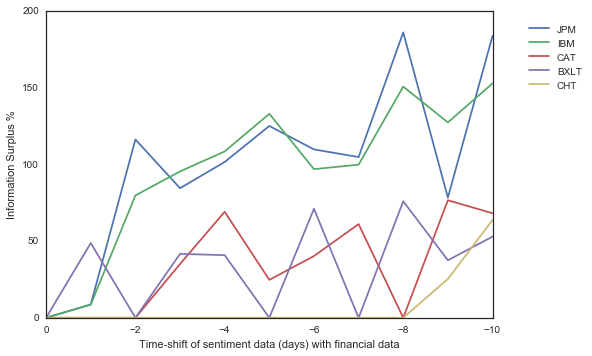

In [125]:
merge_net_mi_res = sentisignal.split_apply_combine(data_nasdaq_top_250_preprocessed_merge, 'SYMBOL', sentisignal.net_information_surplus, 10, 'BULL_MINUS_BEAR', 'LOG_RETURN', -1)
merge_net_mi_res_constr = sentisignal.constrain_mi_res(merge_net_mi_res)
merge_net_mi_res_test = sentisignal.constrain_test_significant(merge_net_mi_res_constr, data_nasdaq_top_250_preprocessed_merge, 'BULL_MINUS_BEAR', 'LOG_RETURN')
sentisignal.plot_inf_res(merge_net_mi_res_test, plot_top=5, time_shift=10)
to_cluster4 = merge_net_mi_res_test

In [145]:
merge_net_mi_res = sentisignal.split_apply_combine(data_nasdaq_top_250_preprocessed_merge, 'SYMBOL', sentisignal.net_information_surplus, 10, 'PCA_SENTIMENT_CHANGE', 'LOG_RETURN', -1)
merge_net_mi_res_constr = sentisignal.constrain_mi_res(merge_net_mi_res)
merge_net_mi_res_test = sentisignal.constrain_test_significant(merge_net_mi_res_constr, data_nasdaq_top_250_preprocessed_merge, 'PCA_SENTIMENT_CHANGE', 'LOG_RETURN')
sentisignal.plot_inf_res(merge_net_mi_res_test, plot_top=5, time_shift=10)
to_cluster5 = merge_net_mi_res_test

length prior to constrain 238
length after to constrain 99
ABEV
ABT
AEP
AET
AFL
ALL
ANTM
AV
AVB
AZN
AZO
BA
BBL
BBT
BMO
BMY
BNS
BSBR
BT
BXLT
CB
CHA
CHL
CHT
CL
CNI
COP
CRM
CS
D
DAL
DCM
DIS
DOW
DUK
E
ECL
EQR
FMS
GGP
GM
HAL
HD
HMC
HON
HUM
IBM
ITW
JCI
JNJ
JPM
KR
LB
LFC
LUX
LYG
MCK
MFC
MHFI
MS
MTU
NTT
ORAN
PEG
PHG
PHI
PPG
PRU
PSA
PTR
PUK
RTN
RY
SAN
SCHW
SLB
SMFG
SPG


KeyboardInterrupt: 